# Survival Analysis of GSL Genes in Glioma

### This analysis is done using TCGA TPM data for LGG accessed from the Xena databse

1. Installing and Importing Packages

In [1]:
# %%capture
# %pip install scipy
# %pip install numpy
# %pip install pandas
# %pip install requests
# %pip install aiohttp
# %pip install pronto
# %pip install matplotlib
# %pip install plotly
# %pip install umap-learn
# %pip install scikit-learn
# %pip install plotly
# %pip install nbformat
# %pip install seaborn
# %pip install hdbscan
# %pip install lifelines
# %pip install scikit-survival

In [2]:
#Importing Packages
import requests
import time
import math

import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import plotly.express as px
import plotly
import plotly.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

import umap.umap_ as UMAP 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from statsmodels.stats.multitest import multipletests

from adjustText import adjust_text

2. Loading in and cleaning Data

In [3]:
df_KM_LGG = pd.read_csv("./TCGA_Data/TCGA_LGG.csv").set_index('sample').dropna()
df_KM_LGG.head()

,OS.time,OS,A4GALT,ABO,B3GALNT1,B3GALT1,B3GALT4,B3GALT5,B3GNT2,B3GNT5,...,ST3GAL6,ST6GALNAC2,ST6GALNAC3,ST6GALNAC4,ST6GALNAC5,ST6GALNAC6,ST8SIA1,ST8SIA5,UGCG,UGT8
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-DB-5277-01,1547.0,1.0,2.0150,-3.626,4.098,1.5410,1.008,-0.1828,2.926,-0.3566,...,2.674,0.4340,3.129,3.994,2.025,5.208,5.364,1.2880,3.313,5.456
TCGA-TM-A84L-01,1242.0,1.0,2.3480,-1.685,2.478,0.6425,2.390,-0.5973,2.465,2.6510,...,5.379,-0.4325,1.566,3.970,-1.355,6.092,4.213,-0.3752,2.644,5.311
TCGA-TM-A7CF-02,1989.0,0.0,1.3850,-3.458,3.074,0.4865,2.196,-1.5520,2.018,0.6332,...,4.242,-0.5973,2.718,3.469,-1.552,5.524,3.522,0.7999,1.710,6.909
TCGA-TM-A7CF-01,1989.0,0.0,0.4865,-2.466,3.798,1.4650,1.043,-1.3180,1.820,0.2522,...,4.012,-1.0560,1.138,3.487,2.499,6.442,3.603,1.2390,2.167,3.818
TCGA-FG-6691-01,1257.0,0.0,1.0570,-2.635,3.819,-0.1345,2.519,-0.1345,3.312,2.8600,...,4.768,1.1450,2.723,3.702,-2.635,5.585,3.776,-2.0530,3.738,5.238


3. Lasso Regression to identify genes of interest

In [4]:
X = df_KM_LGG.drop(columns=["OS","OS.time"])
X = StandardScaler().fit_transform(X)

y = Surv.from_arrays(event=df_KM_LGG["OS"].astype(bool), time=df_KM_LGG["OS.time"].astype(float))

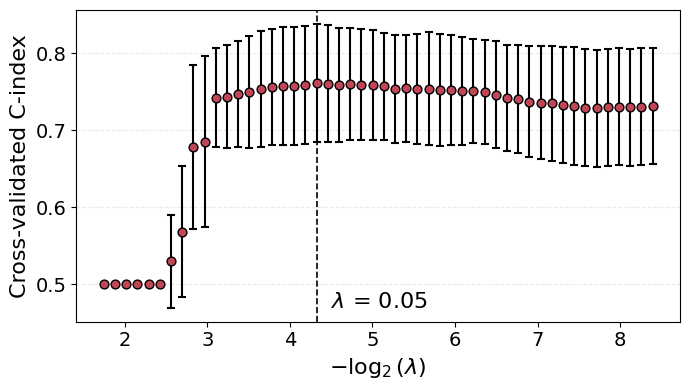

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.exceptions import FitFailedWarning
import warnings

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis

# ---- Fit a quick path to get a dense alpha grid ----
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

# X: your (n x p) matrix or DataFrame of genes (already numeric)
# y: Surv.from_arrays(event=..., time=...)
coxpath = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.5, alpha_min_ratio=0.01, max_iter=100)
)
coxpath.fit(X, y)

estimated_alphas = coxpath.named_steps["coxnetsurvivalanalysis"].alphas_  # descending

# ---- Select exactly 50 alphas, evenly spaced on log-scale (descending) ----
a_max, a_min = estimated_alphas[0], estimated_alphas[-1]
alphas_50 = np.geomspace(a_max, a_min, 50)  # descending -> ascending; reverse:
alphas_50 = alphas_50[::-1]                 # ensure descending like sksurv likes
param_grid = {"coxnetsurvivalanalysis__alphas": [[float(a)] for a in alphas_50]}

# ---- CV grid-search (score = C-index) ----
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1.0)),
    param_grid=param_grid,
    cv=cv,
    error_score=0.5,
    n_jobs=1,
    refit=True,
).fit(X, y)

cv_results = pd.DataFrame(gcv.cv_results_)
alphas = cv_results["param_coxnetsurvivalanalysis__alphas"].map(lambda x: x[0]).astype(float).to_numpy()
mean  = cv_results["mean_test_score"].to_numpy()  # mean C-index
std   = cv_results["std_test_score"].to_numpy()

best_alpha = gcv.best_params_["coxnetsurvivalanalysis__alphas"][0]

# ---- Publication-style plot ----
x = -np.log2(alphas)  # conventional glmnet-style x-axis (larger -> more shrinkage)
x_best = -np.log2(best_alpha)

plt.figure(figsize=(7, 4))
ax = plt.gca()
ax.set_facecolor("white")

# Black error bars with caps
ax.errorbar(
    x, mean, yerr=std, fmt="o", ms=4,
    ecolor="black", elinewidth=1.5, capsize=3, capthick=1.5,
    color="#C04657"
)

# Vertical line at best λ
ax.axvline(x_best, color="black", linestyle="--", linewidth=1.2)

ax.set_xlabel(r"$-\log_2(\lambda)$", fontsize=16)
ax.set_ylabel("Cross-validated C-index", fontsize=16)
idx_best = int(np.argmin(np.abs(alphas - best_alpha)))

# Emphasize the best point
plt.scatter(x, mean, s=40, edgecolor="black", facecolor="#C04657", linewidth=1, zorder=5)

# Annotate with both λ and -log2(λ)
label_txt = f"$\lambda$ = {best_alpha:.2f}"
plt.text(
    x=4.5,
    y=0.47,
    s=label_txt,
    fontsize=16
)
plt.tick_params(axis="both", labelsize=14)
ax.grid(True, axis="y", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()

In [6]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

In [7]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_,index=df_KM_LGG.drop(columns=["OS","OS.time"]).columns, columns=np.round(cox_lasso.alphas_, 5))
coefficients_lasso.head()

,0.14900,0.14223,0.13577,0.12959,0.12370,0.11808,0.11271,0.10759,0.10270,0.09803,...,0.00226,0.00216,0.00206,0.00197,0.00188,0.00179,0.00171,0.00164,0.00156,0.00149
A4GALT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.073698,-0.075422,-0.076828,-0.078273,-0.079673,-0.081010,-0.082282,-0.083502,-0.084578,-0.085577
ABO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.166324,-0.167078,-0.167761,-0.168434,-0.169067,-0.169670,-0.170249,-0.170926,-0.171561,-0.172154
B3GALNT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.009814,-0.012275,-0.014107,-0.016083,-0.017984,-0.019793,-0.021514,-0.023133,-0.024650,-0.026090
B3GALT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.158687,0.159092,0.159888,0.160483,0.161016,0.161521,0.162004,0.162369,0.162672,0.162921
B3GALT4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.020034,-0.021839,-0.023257,-0.024734,-0.026166,-0.027534,-0.028838,-0.029962,-0.030925,-0.031782


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_coef_path_pub(
    coef_path_df: pd.DataFrame,   # rows=genes, cols=alphas (floats, typically descending)
    alpha_star: float,            # chosen/best lambda
    epsilon: float = 1e-12,
    savepath: str | None = None,
    connector_dx: float = 0.25,   # how far to the right to place labels
):
    alphas = np.asarray(coef_path_df.columns, dtype=float)     # descending
    xvals  = -np.log2(alphas)
    x_star = -np.log2(alpha_star)

    # coefficients at alpha_star (interpolate if needed)
    if np.any(np.isclose(alphas, alpha_star, rtol=1e-10, atol=1e-12)):
        a_star_exact = alphas[np.argmin(np.abs(alphas - alpha_star))]
        coefs_at_star = coef_path_df[a_star_exact]
    else:
        order = np.argsort(alphas)  # ascending for interp
        a_sorted = alphas[order]
        coefs_at_star = coef_path_df.iloc[:, order].apply(
            lambda row: np.interp(alpha_star, a_sorted, row.values), axis=1
        )

    # select non-zero features at alpha_star
    nz = coefs_at_star.abs() > epsilon
    selected = coefs_at_star.index[nz].tolist()

    # plotting
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_facecolor("white")

    # all paths in light grey
    for _, row in coef_path_df.iterrows():
        ax.plot(xvals, row.values, color="#bdbdbd", lw=1.0, alpha=0.8, zorder=1)

    # highlight selected paths
    cmap = plt.get_cmap("tab10")
    end_x = xvals[-1]
    x_lab = end_x + connector_dx
    colors = {g: cmap(i % 10) for i, g in enumerate(selected)}
    y_end  = {g: coef_path_df.loc[g].values[-1] for g in selected}

    for g in selected:
        ax.plot(xvals, coef_path_df.loc[g].values, lw=2.5, color=colors[g], zorder=3)

    # vertical line at chosen lambda
    ax.axvline(x_star, ls="--", color="black", lw=1.2)

    ax.set_xlabel(r"$-\log_2(\lambda)$", fontsize=16)
    ax.set_ylabel("Coefficient", fontsize=16)
    ax.grid(True, axis="y", ls="--", alpha=0.25)

    # --- ensure labels aren't clipped horizontally ---
    # pad the right x-limit to include x_lab (and a little extra for the label box)
    xmin, xmax = xvals.min(), xvals.max()
    ax.set_xlim(xmin, 10.5)

    # --- add labels at fixed x, repel only in Y ---
    texts = []
    for g in selected:
        txt = ax.text(
            x_lab, y_end[g], g, ha="left", va="center", fontsize=12, zorder=5,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=colors[g], lw=1.2)
        )
        texts.append(txt)

    # repel vertically ONLY; keep x fixed
    adjust_text(
        texts,
        ax=ax,
        only_move={'text': 'y', 'points': '', 'objects': ''},
        expand_text=(1.02, 1.10),
        force_text=0.6,
        lim=300,
        autoalign='y'
    )

    # now draw connectors to the final label positions
    for g, txt in zip(selected, texts):
        x_text, y_text = txt.get_position()
        ax.plot([end_x, x_text], [y_end[g], y_text], color=colors[g], lw=1.2, zorder=4)
    
    label_txt = f"$\lambda$ = {best_alpha:.2f}"
    plt.text(
        x =4.5,
        y=0.-0.35,
        s=label_txt,
        fontsize=16
    )
    plt.tick_params(axis="both", labelsize=14)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
        plt.close(fig)
    else:
        plt.show()

    return selected


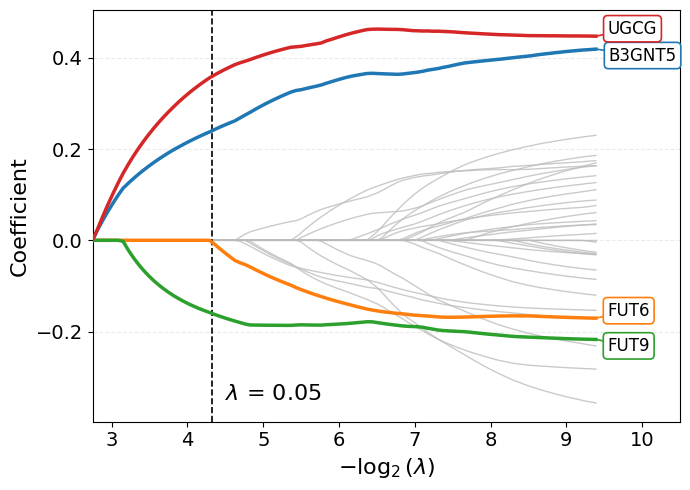

In [9]:
selected_genes = plot_coef_path_pub(
    coef_path_df=coefficients_lasso,
    alpha_star=float(best_alpha),
    connector_dx=0.1
)

### KM analysis of Lesso regression identified genes

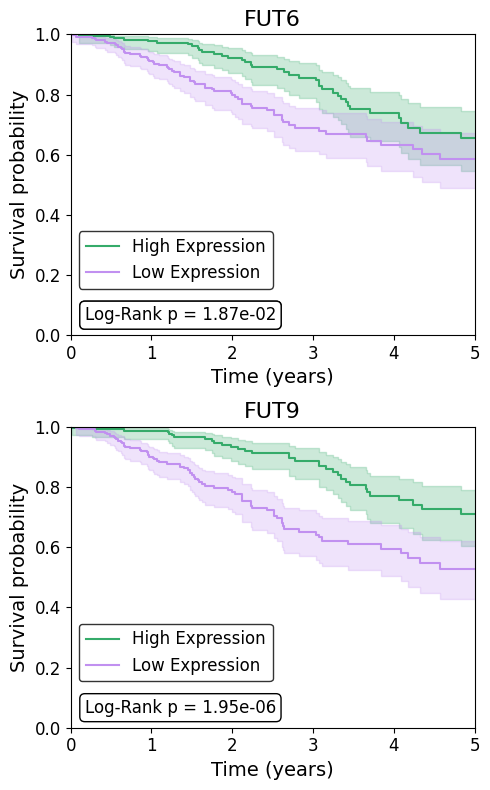

In [10]:
genes_of_interest = ["FUT6","FUT9"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 8))
logrank_ps = []
for idx, gene_of_interest in enumerate(genes_of_interest):
    df_Expn_Class = df_KM_LGG.copy()

    def Expn_class(x):
        return "High" if x > df_Expn_Class[gene_of_interest].median() else "Low"

    df_Expn_Class["Expression Class"] = df_Expn_Class[gene_of_interest].apply(Expn_class)
    df_Expn_Class = df_Expn_Class.dropna()
    df_Expn_Class["Expression_Class_Num"] = df_Expn_Class["Expression Class"].map({"Low": 0, "High": 1})
    df_cox = df_Expn_Class[["OS.time", "OS", "Expression_Class_Num"]]

    high = df_Expn_Class[df_Expn_Class["Expression Class"] == "High"]
    low  = df_Expn_Class[df_Expn_Class["Expression Class"] == "Low"]
    lr_res = logrank_test(
        high["OS.time"], low["OS.time"],
        event_observed_A=high["OS"], event_observed_B=low["OS"]
    )
    p_val = lr_res.p_value
    logrank_ps.append(p_val)

    kmf = KaplanMeierFitter()
    colours = ["#35AB6A", "#C190F0"]
    
    ax = axs[idx]  # Select the subplot axis
    for i, (cluster, group_df) in enumerate(df_Expn_Class.groupby("Expression Class")):
        kmf.fit(group_df["OS.time"] / 365, event_observed=group_df["OS"], label=f"{cluster} Expression")
        kmf.plot_survival_function(ax=ax, color=colours[i])

    ax.set_title(f"{gene_of_interest}", fontsize=16)
    ax.set_xlim(0, 5)
    ax.set_ylim(0.0,1)
    ax.set_ylabel("Survival probability", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel("Time (years)",fontsize=14)
    p_vals = logrank_ps
    for ax, p in zip(axs, p_vals):
        ax.text(
            0.035, 0.05,
            f"Log-Rank p = {p:.2e}",
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white",edgecolor='black')
        )

    ax.legend(fontsize=12, title_fontsize=12, loc = 'center left',bbox_to_anchor=(0,0.25),edgecolor='black')

plt.tight_layout()
plt.show()

### Cox (Ridge L2 penalised) Regression for C index and Hazard Ratio calculation

0.7794362653428989


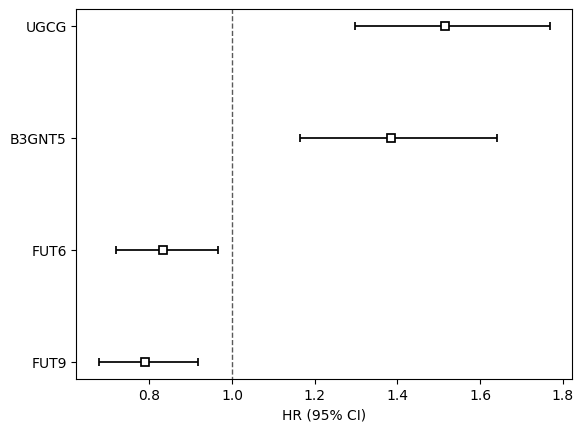

In [11]:
genes_of_interest = ["B3GNT5", "UGCG", "FUT9","FUT6"]
genes_df = df_KM_LGG[["OS","OS.time"]+genes_of_interest].copy()
cox_scaler = StandardScaler()
genes_df[genes_of_interest] = cox_scaler.fit_transform(genes_df[genes_of_interest])

cph = CoxPHFitter(penalizer=best_alpha, l1_ratio=0.0)
cph.fit(genes_df,duration_col="OS.time",event_col="OS",robust=True)

cindex = cph.concordance_index_

print(cindex)
ax = cph.plot(hazard_ratios=True)


In [12]:
summary = cph.summary.reset_index().rename(columns={'index': 'Gene'})
hr_df = summary.rename(columns={
    "exp(coef)": "HR",
    "exp(coef) lower 95%": "CI_lower",
    "exp(coef) upper 95%": "CI_upper",
    "covariate":"Gene"
})

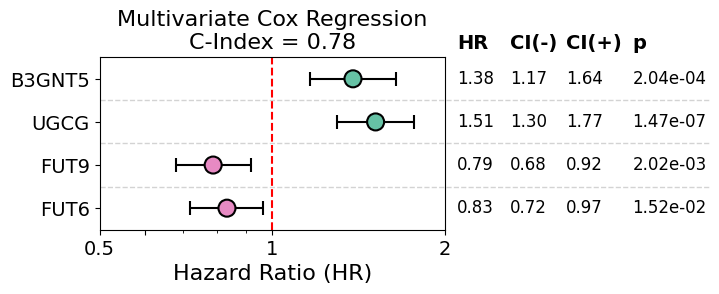

In [13]:
def plot_forest_grid(hr_df, p_thresh=0.05):
    sig_df = hr_df

    def sig_class(p, hr):
        if p < p_thresh:
            if hr > 1:
                return 2
            elif hr < 1:
                return 1
        else:
            return 0
    
    sig_df["Sig"] = sig_df.apply(lambda x: sig_class(x.p, x.HR),axis=1)

    # Create grid spec with extra column for colorbar
    fig = plt.figure(figsize=(12,8),constrained_layout=True)  # extra width for colorbar
    gs = fig.add_gridspec(4, 2, width_ratios=[1,0.7])

    ax = fig.add_subplot(gs[1, 1])

    df_cancer = sig_df
    ax.errorbar(df_cancer["HR"], df_cancer["Gene"],
                xerr=[df_cancer["HR"] - df_cancer["CI_lower"], df_cancer["CI_upper"] - df_cancer["HR"]],
                fmt='none', ecolor='black', capsize=5, elinewidth=1.5, capthick=1.5,zorder=1)

    ax.scatter(df_cancer["HR"], df_cancer["Gene"],
                c=df_cancer["Sig"], cmap='Set2_r',
                linewidths=1.5, edgecolors='black',
                zorder=2,vmin=0,s=150)
    
    for y, hr, p, low_ci, up_ci in zip(df_cancer["Gene"], df_cancer["HR"] ,df_cancer["p"], df_cancer["CI_lower"],df_cancer["CI_upper"]):
        ax.text(2.1, y, f"{hr:.2f}", va='center', fontsize=12)
        ax.text(2.6, y, f"{low_ci:.2f}", va='center', fontsize=12)
        ax.text(3.25, y, f"{up_ci:.2f}", va='center', fontsize=12)
        ax.text(4.25, y, f"{p:.2e}", va='center', fontsize=12)

    ax.text(2.1, -0.7, "HR", fontsize=14, fontweight='bold')
    ax.text(2.6, -0.7, "CI(-)", fontsize=14, fontweight='bold')
    ax.text(3.25, -0.7, "CI(+)", fontsize=14, fontweight='bold')
    ax.text(4.25, -0.7, "p", fontsize=14, fontweight='bold')

    ax.axvline(1, color='red', linestyle='--')
    ax.set_xlim(0.5,2)
    ax.set_ylim(-0.5,3.5)
    ax.invert_yaxis()
    ax.set_title(f"Multivariate Cox Regression\nC-Index = {cindex:.2f}",fontsize=16)
    ax.set_xlabel("Hazard Ratio (HR)",fontsize=16)
    ax.semilogx()
    plt.xticks(ticks=[0.5,0.6,1,2], labels=[0.5,"",1,2])
    ax.tick_params(axis='both',labelsize=14)
    for line_pos in range(0,3):
        ax.axhline(line_pos+0.5,color='lightgray', linestyle='--', linewidth=1)
    fig.canvas.draw()
    x_left_fig = ax.get_position().x0
    x_right_fig = ax.get_position().x1
    for yi in range(0,3):
        y_data = yi + 0.5
        _, y_disp = ax.transData.transform((0, y_data))
        _, y_fig = fig.transFigure.inverted().transform((0, y_disp))
        line = Line2D([x_left_fig, x_right_fig+0.22], [y_fig, y_fig], transform=fig.transFigure,
                      color='lightgray', linestyle='--', linewidth=1, zorder=0)
        fig.add_artist(line)

    plt.show()
plot_forest_grid(hr_df, p_thresh=0.05)

### Calculating Cox Regression Risk Scores for initial KM analysis

In [14]:
summary_extraction = summary.set_index('covariate')
B3GNT5_coef = summary_extraction.loc["B3GNT5"]["coef"]
UGCG_coef = summary_extraction.loc["UGCG"]["coef"]
FUT9_coef = summary_extraction.loc["FUT9"]["coef"]
FUT6_coef = summary_extraction.loc["FUT6"]["coef"]

In [15]:
genes_df["Risk_Score"] = (genes_df["B3GNT5"] * B3GNT5_coef) + (genes_df["UGCG"]*UGCG_coef) + (genes_df["FUT9"]*FUT9_coef) + (genes_df["FUT6"]*FUT6_coef)

def tune_threshold_by_logrank(
    probs_train: np.ndarray,
    time_train: np.ndarray,
    event_train: np.ndarray,
) -> tuple[float, float]:
    
    probs_train = np.asarray(probs_train, float).ravel()
    time_train  = np.asarray(time_train,  float).ravel()
    event_train = np.asarray(event_train, bool).ravel()

    # Candidate thresholds from fixed quantiles in [0.20, 0.80]
    qs    = np.linspace(0.20, 0.80, 41)
    cands = np.unique(np.quantile(probs_train, qs))

    best_thr  = float(np.median(probs_train))
    best_stat = -np.inf
    found     = False

    for thr in cands:
        hi = probs_train >= thr
        lo = ~hi
        if hi.sum() == 0 or lo.sum() == 0:
            continue
        try:
            lr = logrank_test(
                time_train[hi], time_train[lo],
                event_observed_A=event_train[hi],
                event_observed_B=event_train[lo],
            )
            chi2 = float(lr.test_statistic)
            if np.isfinite(chi2) and chi2 > best_stat:
                best_stat = chi2
                best_thr  = float(thr)
                found     = True
        except Exception:
            continue

    if not found:
        # fallback: median threshold, 0 separation
        return float(np.median(probs_train)), 0.0

    return best_thr, best_stat

thr, stat = tune_threshold_by_logrank(genes_df['Risk_Score'].to_numpy(), genes_df["OS.time"].to_numpy(),genes_df["OS"].to_numpy())
print(f"Best Threshold: {thr}")

Best Threshold: 0.45426107657382364


In [16]:
CGGA_df = pd.read_csv("./CGGA_Data/CGGA_LGG_TPM.csv").set_index("CGGA_ID").dropna()
CGGA_df = CGGA_df[["OS","OS.time"]+genes_of_interest].copy()
CGGA_df[genes_of_interest] = cox_scaler.transform(CGGA_df[genes_of_interest])
CGGA_df["Risk_Score"] = (CGGA_df["B3GNT5"] * B3GNT5_coef) + (CGGA_df["UGCG"]*UGCG_coef) + (CGGA_df["FUT9"]*FUT9_coef) + (CGGA_df["FUT6"]*FUT6_coef)
def Risk_class(x):
    return 1 if x > thr else 0
CGGA_df["Risk Class"] = CGGA_df["Risk_Score"].apply(Risk_class)

In [17]:
CGGA_df.head()

,OS,OS.time,B3GNT5,UGCG,FUT9,FUT6,Risk_Score,Risk Class
CGGA_ID,,,,,,,,
CGGA_1002,1.0,305.0,0.167627,-0.614143,-0.403444,1.010654,-0.288567,0
CGGA_1003,0.0,3817.0,-1.137395,-1.717910,-1.336039,-1.045474,-0.575869,0
CGGA_1010,1.0,246.0,-4.425060,-9.996391,-6.253457,-0.082568,-4.089740,0
CGGA_1012,1.0,3679.0,-0.582293,-0.624705,-0.523556,1.417725,-0.581730,0
CGGA_1014,1.0,263.0,0.718331,-0.903328,-0.726267,-1.045474,0.219984,0


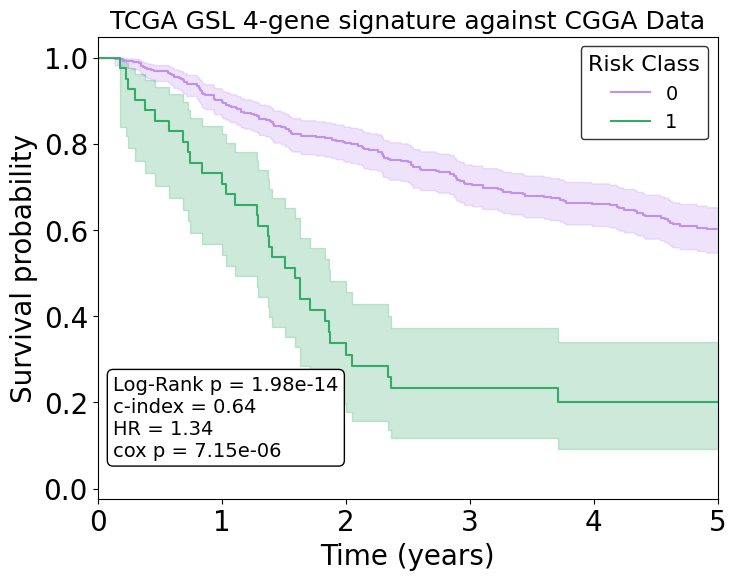

In [19]:
# Initialize the plot
fig = plt.figure(figsize=(8, 6))

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()
colours = ["#C190F0","#35AB6A"]

high = CGGA_df[CGGA_df["Risk Class"] == 1]
low  = CGGA_df[CGGA_df["Risk Class"] == 0]
lr_res = logrank_test(
    high["OS.time"], low["OS.time"],
    event_observed_A=high["OS"], event_observed_B=low["OS"]
)
p_val = lr_res.p_value
cph_df = CGGA_df[["OS","OS.time","Risk_Score"]]
cph_CGGA = CoxPHFitter(penalizer=0.05, l1_ratio=0.0)
cph_CGGA.fit(cph_df, duration_col = "OS.time", event_col="OS", robust=True)

cindex = cph_CGGA.concordance_index_
hr = cph_CGGA.summary["exp(coef)"].values[0]
hr_p = cph_CGGA.summary["p"].values[0]

i=0
# Loop through each cluster and plot its survival curve
for cluster, group_df in CGGA_df.groupby("Risk Class"):  
    kmf.fit(group_df["OS.time"]/365, event_observed=group_df["OS"], label=f"{cluster}")
    ax = kmf.plot_survival_function(color=colours[i])
    i +=1
    ax.set_xlim(0,5)
    ax.set_xlabel("Time (years)",fontsize=20)
    ax.set_ylabel("Survival probability",fontsize=20)
    ax.tick_params(axis='both',labelsize=20)
ax.legend(fontsize=14, title="Risk Class", title_fontsize=16,loc="upper right",edgecolor='black')
ax.text(
            0.125, 0.075,
            f"Log-Rank p = {p_val:.2e}\nc-index = {cindex:.2f}\nHR = {hr:.2f}\ncox p = {hr_p:.2e}",
            fontsize=14,
            bbox=dict(boxstyle="round", facecolor="white",edgecolor='black')
        )
plt.title("TCGA GSL 4-gene signature against CGGA Data", fontsize=18)
plt.show()
